In [300]:
# general import
import os
import pickle
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import copy

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# my own
from tasks import get_data
from myutils import *
from topology import gen_lattice, compute_dist

# increase cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

dtype = torch.float
device = torch.device("cpu")

# SOME USEFUL DEFINITIONS
relu = lambda x : (x > 0) * x
def pr(h, b):
    if b > 1e2:
        return 1. * (h > 0)
    else:
        return np.exp(b * h) / (2 * np.cosh(b * h))

## Set task

### Available task:

Random Tasks:
- __RANDOM__ : random iid gaussian inputs mapped to random binary outputs
- __RANDOM-Y__ : random iid gaussian inputs mapped to random gaussian outputs
- __NLGP__ : spatially correlated inputs with output labels defined by their correlation length
- __RANDOM-FF-Teacher__: random Feed Forward teacher networkm with two layers with binary output
- __RANDOM-FF-Teacher-Y__: random Feed Forward teacher network with two layers with continuous output
- __RANDOM-RNN-Teacher__ : random Recurrent teacher network with binary output
- __RANDOM-RNN-Teacher-X__ : random Recurrent teacher network targets defined as steady state activities
- __RANDOM-RNN-Teacher-Y__ : random Recurrent teacher network with continuous output


Datasets:
- __MNIST1D__
- __MNIST__
- __MNIST10__
- __FashionMNIST__
- __CIFAR10__
- __CIFAR100__

In [301]:
# SET MAIN PARAMS

pars = Pars()

## random task name
# pars.dataset = "RANDOM"
# pars.dataset = "RANDOM-Y"
pars.dataset = "NLGP"
# pars.dataset = "RANDOM-FF-Teacher"
# pars.dataset = "RANDOM-FF-Teacher-Y"
# pars.dataset = "RANDOM-RNN-Teacher"
# pars.dataset = "RANDOM-RNN-Teacher-X"
# pars.dataset = "RANDOM-RNN-Teacher-Y"

## dataset name
# pars.dataset = "MNIST1D"
# pars.dataset = "MNIST"
# pars.dataset = "MNIST10"
# pars.dataset = "FashionMNIST"
# pars.dataset = "CIFAR10"
# pars.dataset = "CIFAR100"

# General options
pars.alpha_train = 0.1 # fraction of training patterns wrt N in a random task
pars.alpha_test = 0.1 # fraction of test patterns wrt N in a random task
pars.span_h = False # generate all h in range (only makes sense for N=2 or N=3)

## random dataset specific options
pars.exp_input = False # exponentially distributed input (default is gaussian)
pars.rho = 0. # input covariance for RANDOM dataset

## teacher-student FF options
pars_teacher = {}
# pars_teacher["K"] = 1 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "linear" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = True # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 1. # gain of ff weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

# ## teacher-student RNN options
# pars_teacher = {}
# pars_teacher["K"] = 40 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "relu" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["discrete_time"] = False # type of temporal dynamics
# pars_teacher["dt"] = 0.1 # time discretization
# pars_teacher["eye_in"] = True # identity input weights
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = False # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 0.8 # gain of recurrent weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

## NLGP specific options
pars.torus = True # whether to use a torus topology
pars.g_nonlin = 1e-10 # gain parameter for nonlinearity
pars.xis = [1e-6] # lenght-scales of mixtures

## spatial options
pars.dim = 1 # input dimension
pars.lN =100 # linear input size
pars.normalize = False # normalize inputs (some dataset are already normalized)

## misc options
pars.seed_data = 10
pars.data_dir = f'data'
pars.save_dir = f'results_notebook'

# # TO DIRECTLY DOWNLOAD MNIST1D USE THE FOLLOWING:
# import requests
# url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
# r = requests.get(url, allow_redirects=True)
# save_dir_dataset = save_dir + "/" + dataset
# open(f'{data_dir}/mnist1d_data.pkl', 'wb').write(r.content)

In [302]:
# GET DATASET
makedir(pars.data_dir)
data_and_properties = get_data(pars, dtype=dtype, device=device)
train_dataset, test_dataset, teacher_weights, x_teacher = data_and_properties
print(f"{pars.dim} dimensional inputs of size {pars.lN}^{pars.dim} = {pars.N}")
print(f"num train: {pars.num_train}, num test: {pars.num_test}, num label: {pars.num_label}")

1 dimensional inputs of size 100^1 = 100
num train: 10, num test: 10, num label: 1


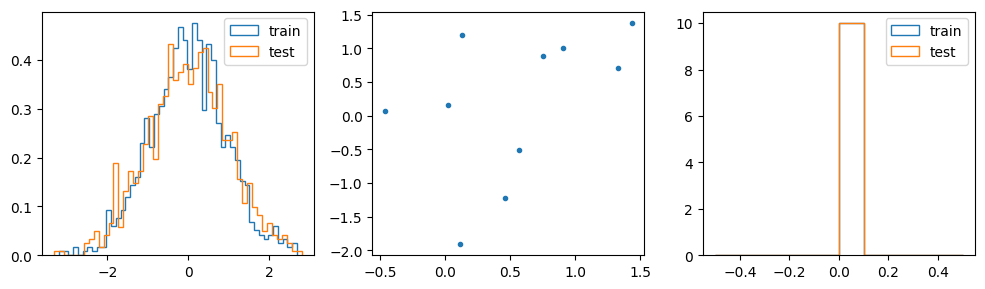

In [303]:
# WATCH RANDOM DATA DISTRIBUTION

if "RANDOM" in pars.dataset or "GP" in pars.dataset:
    plt.figure(figsize=(10,3))

    X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)
    if pars.num_test is not None:
        X_to_plot_test, y_to_plot_test = extract_tensors(test_dataset)
    
    # Plot distribution of all obtained datapoints (both train and test)
    plt.subplot(131)
    plt.hist(X_to_plot_train.flatten().tolist(), bins=50, density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(X_to_plot_test.flatten().tolist(), bins=50, density=True, histtype="step", label="test");
    plt.legend();

    # First data-point vs 2nd data-point, to see correlation between them (only training dataset)
    plt.subplot(132)
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,1], '.');
#     plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,2], '.');

    # Distribution of all values obtained for y (both train and test)
    plt.subplot(133)
    plt.hist(y_to_plot_train.flatten().tolist(), density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(y_to_plot_test.flatten().tolist(), density=True, histtype="step", label="test");
    plt.legend();

    plt.tight_layout()

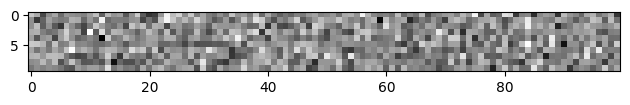

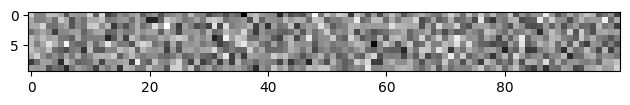

In [304]:
# WATCH DATASET
watch_dataset(train_dataset, test_dataset, pars)

## Run learning

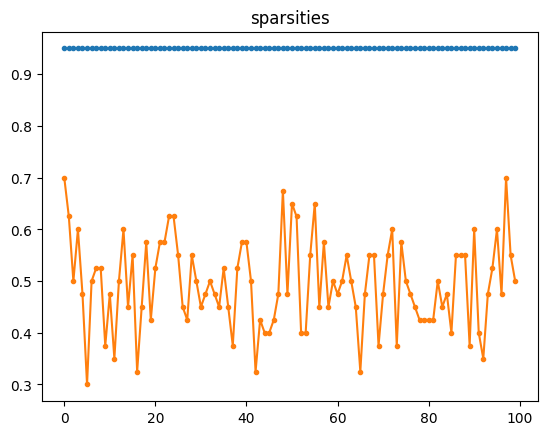

In [305]:
sparsities = np.ones(N) * 0.95
plt.plot(sparsities, '.:')
plt.plot(X.mean(0), '.-')
plt.title('sparsities');

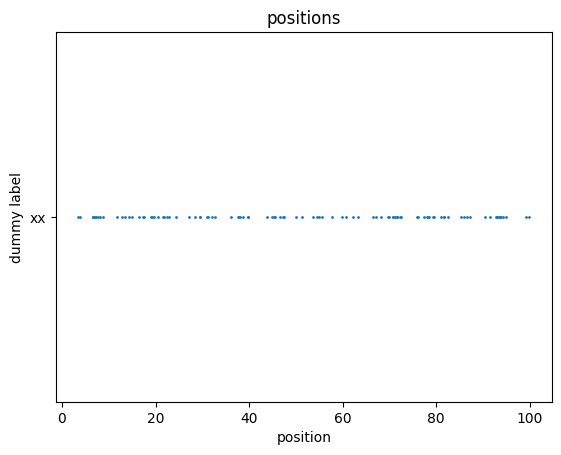

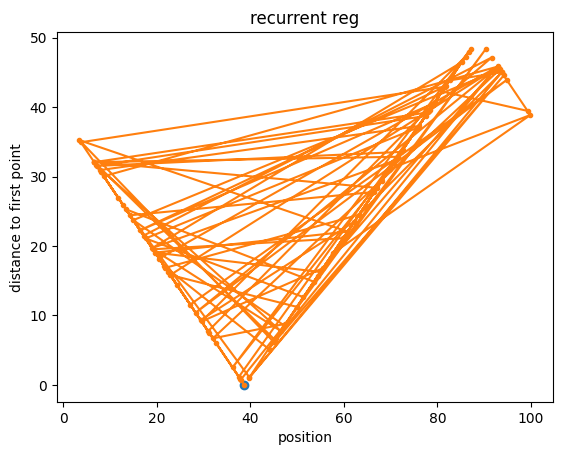

In [400]:
# network options
lN, N = pars.lN, pars.N            # Size of the patterns to be learned (lN for linear dimension, N for total dimension)
P = pars.num_train                 # Number of patterns to learn
fe = -1                            # Fraction of excitatory connections
sparsity_mean = 0.                 # If you use sparsity instead of sign(train_dataset), you'll generate a sequence 
#                                  # which will be later give the probability to have a 0 in X
sparsity_std = 0.                  # To control std for sparsity
noself = True                      # Set diagonal to 0, to prevent trivial solution J=id(NxN)
use_bias = True                    # Use a bias (I, input current): H = JX + I
learn_bias = True                  # Learn bias or not (fix it instead)
bias = 0.                          # Initialize the bias 
norm_dependent_stability = False   # Stability is proportional to ||J^2|| (otherwise it's proportional to sqrt(N))
embed_model = True                 # Embed the model to a graph
random_pos = True                 # Embeded positions are random
dim = pars.dim                     # Dimension of the data (it's already previously defined)
torus = pars.torus                 # Whether to use a torus topology (alreade defined previously)

# learning options
num_epochs = 200          # Number of epochs
print_every = 10          # Verbose option
lr = 0.1                 # Learning rate
delta0 = 0.5              # Stability regularization
gam = 0.                  # Regularization strength (L1?)
gam_en = 0.               # Energy regularization
gam_sign = 0.5            # Sign regularization
gam_pos = 0.              # Position regularization (?)
relu2 = True             # Whether to use relu or relu^2 as activation function 
maxweight = 10           # Don't let weight be too large
square_dist = False       # Whether to set distance as (xi^2+xj^2) or as np.abs(xi^2+xj^2)
stop_at_zero_err = False  # You may want to continue training after 0 error because sign regularization can still improve

# ## homogeneous sparsities
# sparsities = sparsity_mean + np.random.randn(N) * sparsity_std
# sparsities = np.clip(sparsities, a_min=0, a_max=1)
# ## space-dependent sparsities
# sparsities = np.linspace(0.9, 0.1, N)
# sparsities = np.ones(N) * 0.95
# sparsities[:N//2] = 0.15

# gen patterns
# X = 1. * (np.random.rand(P,N) <= sparsities[None])
X = 0.5 * (1 + np.sign(train_dataset.tensors[0].numpy()))
Y = 2. * X - 1.

# if sparsity_std > 0: # Plot sparsities vs X
#     plt.plot(sparsities, '.:')
#     plt.plot(X.mean(0), '.-')
#     plt.title('sparsities');
    
## init J
Ne = int(fe * N)                             # Initial fraction of excitatory connections
I = bias * np.ones(N)                        # Initial bias (convert to vector, same initial values for each entry)
if fe == -1:                               # If  not ordered excitatory/inhibitory connections
    J = np.random.randn(N, N) / np.sqrt(N)   # Initialize J randomly ~ Gaussian(0,1)
else:                                      # If ordered E/I connections
    J = np.random.rand(N, N) / np.sqrt(N)    # Initialize J randomly ~ Uniform(0,1)
    J[:,Ne:] *= -1.                          # And force a fraction of the entries to be negative
diag_indices = np.diag_indices(N)          # To set J(diagonal) = 0 if noself
if noself:
    J[diag_indices] = 0.

## generate positions    
if embed_model:                              # Embed ANN to a space (1-D or 2-D, 3-D is not yet implemented)
    if dim == 1:                         # For 1-D
        L = N                                # Linear dimension
        totpoints = [L]                      # Initialize position vector
    elif dim == 2:                       # For 2-D
        L = int(np.sqrt(N))                  # Linear dimension (should be sqrt(N))
        if L**2 != N:                        # If L^2 !=N, throw an error
            print("WARNING: need a perfect square in dimension 2")
        totpoints = [L, L]                   # Initialize position matrix
    else:                                # dimension >= 3 is not implemented yet
        raise ValueError("dim = 3 not implemented yet!")

    pos = gen_lattice(dim=dim, lens=[L,L], torus=torus, random_pos=random_pos, tot_points=totpoints, centered=False)  # Generate position matrix
    dist = compute_dist(dim, pos, pos, lens=[L,L], torus=torus, square=square_dist)                              # Generate distances matrix
    # dist = np.tanh(dist/10) * 10             # Can force distance matrix to have a certain distribution, such as a tanh
    pos = pos.numpy()                          # Convert position matrix to numpy array
    dist = dist.numpy()                        # Convert distance matrix to a numpy array

    # visualize positions
    if dim == 1:                                             # Plot position matrices (only if embeded to 1-D)
        plotmax=N                                            # Max number of points to plot, to avoid overloading the image
        plt.plot(pos[0:plotmax], 0 * np.ones_like(pos[0:plotmax]), 'o', ms=1)      # Do the plot
        plt.title('positions')                               # Title
        plt.yticks([0],['xx'])                               # Hide y axis
        plt.xlabel('position')
        plt.ylabel('dummy label')
        plt.show()                                           # Show


        # recurrent reg
        i_plot = [0]#[L//2]                       # Take one neuron (the one in the middle, which can have a random position)
        for i in i_plot:                      # Plot distances from that neuron to the others
            plt.plot(pos[i], 0, 'o', label='first point')
            plt.plot(pos[0:plotmax], dist[i_plot[0],0:plotmax], '.-')
        plt.xlabel('position')
        plt.ylabel('distance to first point')
        plt.title('recurrent reg')
        plt.show()

In [401]:
print(pos[0:plotmax])
print(dist[0,0:plotmax])

[38.736935  37.86977   30.99789   79.3099    16.472036  81.75056
 79.486115  39.79401   93.71686   82.59082   57.713997  99.868996
 69.86869   36.22003   87.121254  70.65576   78.224396  69.61826
 70.796326  80.99394   99.280174  93.74497   63.237797  21.870773
  8.132183   3.7928402 81.69919   68.09981   86.659035  85.21186
 19.037914  71.101654  55.00007   19.683563  60.814117   3.501141
 44.96122   92.852776  55.553646  29.598093  86.02572   66.52396
 14.30757   39.82343   94.17431   43.92854   21.646803  24.30687
 22.436327   8.687991  92.89366   20.53674   37.98315   47.536022
 32.032055  93.31479   15.007359  47.27838   90.35376   54.44892
 45.42958   45.239216   6.657672  11.789263  32.635635   7.0961356
 46.509613  19.207699  59.86855   53.596146  13.454562  17.22582
 91.5897    77.97632    6.658244  71.59096   49.97618   22.907913
 92.93911   28.336275  94.81949   27.171612  12.835807  37.570595
 78.37519   72.55766   71.550804  72.29307    7.201666  77.46666
 51.380283  17.64

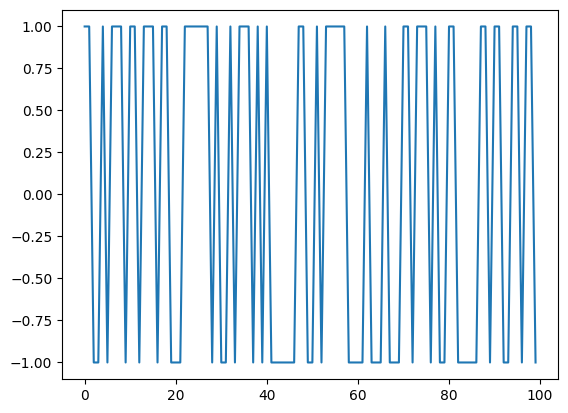

In [402]:
plt.plot(Y[0,:])

In [403]:
# init containers
J0 = J.copy()
errs, en_regs, sign_regs, pos_regs = [], [], [], []

# run optimization    
ok = False
for ep in range(num_epochs):
    
    # run through data
    perm = np.random.permutation(P)
    for mu in perm:
        
        # compute fields
        H = J @ X[mu]
        if use_bias:
            H += I
            
        # learning step
        delta = delta0 * np.sqrt((J**2).sum(-1)) if norm_dependent_stability else delta0 * np.sqrt(N)
        err = Y[mu] * ((Y[mu] * H) <= delta) #Should be <= ?
        derr = np.outer(err, X[mu])
        J += lr * derr
        J -= lr * gam * J
        
        # train input bias
        if use_bias and learn_bias:
            I += lr * err
        
        # apply energy regularization
        if gam_en:
            en_reg = 0.5 * (J**2 @ X[mu]).mean()
            J -= lr * gam_en * J * X[mu][None]

        # apply sign regularization
        if gam_sign:
            if relu2:
                reluscorr = relu(-np.einsum('ki,li->kli', J, J))
                sign_reg = 0.25 * (reluscorr**2).sum() / N**2
                dsign_reg = -np.einsum('kli,li->ki' ,reluscorr, J)
            else:
                scorr = -np.einsum('ki,li->kli', J, J)
                thetascorr = 1. * (scorr >= 0)            
                sign_reg = 0.5 * (thetascorr * scorr).sum() / N**2
                dsign_reg = -np.einsum('ijk,ji->ik', thetascorr, J)
            J -= lr * gam_sign * dsign_reg
            
        # apply position regularization
        if gam_pos:
            J -= lr * gam_pos * J * dist
                        
        # enforce constraints
        if Ne > -1:
            np.clip(J[:,:Ne], 0., maxweight, out=J[:,:Ne])
            np.clip(J[:,Ne:], -maxweight, 0., out=J[:,Ne:])
            #Need to inforce maxweight for Ne==-1, maybe do else: np.clip(J[:,:], -maxweight, maxweigh, out=J[:,:])
        else:
            np.clip(J, -maxweight, maxweight, out=J)
        if noself:
            J[diag_indices] = 0.
                        
    # compute errors and print
    if ep % print_every == 0:
        
        # compute loss on entire training set
        Hs = X @ J.T
        if use_bias:
            Hs += I[None]
        err = ((Hs * Y) <= delta).mean()
        errs += [err]
        
        # compute en reg
        if gam_en:
            en_reg = 0.5 * (X @ J**2).mean()
            en_regs += [en_reg]
        
        # compute sign reg on J
        if gam_sign:
            reluscorr = relu(-np.einsum('ik,jk->ijk', J, J))
            if relu2:
                sign_reg = 0.25 * (reluscorr**2).sum() / N**2
            else:
                sign_reg = 0.5 * reluscorr.sum() / N**2
            sign_regs += [sign_reg]
        
        if gam_pos:
            pos_reg = 0.5 * (J**2 * dist).mean()
            pos_regs += [pos_reg]
        
        # print info
        toprint = f'ep: {ep} loss: {err}'
        if gam_en:
            toprint += f' en reg: {en_reg}'
        if gam_sign:
            toprint += f' sign reg: {sign_reg}'
        if gam_pos:
            toprint += f' pos reg: {pos_reg}'
        print(toprint)
        
        # optionally stop at convergence
        if err.sum() == 0:
            if not ok:
                ep_conv = ep
                ok = True
            if stop_at_zero_err:
                break
                
if not ok:
    print(f'loss not zero in {ep} epochs - min av error {errs[-1]}')
else:
    print(f'zero loss converged at {ep_conv} epochs')

ep: 0 loss: 0.733 sign reg: 0.004845099272853802
ep: 10 loss: 0.385 sign reg: 0.0003571018078733564
ep: 20 loss: 0.156 sign reg: 9.26013001919428e-05
ep: 30 loss: 0.039 sign reg: 4.9950566342278766e-05
ep: 40 loss: 0.002 sign reg: 4.509565568453236e-06
ep: 50 loss: 0.0 sign reg: 1.2322971215407377e-07
ep: 60 loss: 0.0 sign reg: 9.091670760427214e-09
ep: 70 loss: 0.0 sign reg: 7.960848933405561e-10
ep: 80 loss: 0.0 sign reg: 7.259279156603101e-11
ep: 90 loss: 0.0 sign reg: 6.6831343524125115e-12
ep: 100 loss: 0.0 sign reg: 6.166821781791189e-13
ep: 110 loss: 0.0 sign reg: 5.693554942323341e-14
ep: 120 loss: 0.0 sign reg: 5.257318833784907e-15
ep: 130 loss: 0.0 sign reg: 4.854666977467414e-16
ep: 140 loss: 0.0 sign reg: 4.4828898949852185e-17
ep: 150 loss: 0.0 sign reg: 4.139592172856416e-18
ep: 160 loss: 0.0 sign reg: 3.8225858805006807e-19
ep: 170 loss: 0.0 sign reg: 3.5298560644840965e-20
ep: 180 loss: 0.0 sign reg: 3.2595432998913924e-21
ep: 190 loss: 0.0 sign reg: 3.0099308313556777

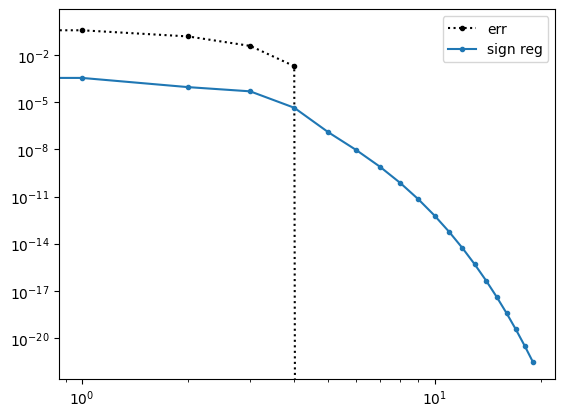

In [404]:
plt.plot(errs, '.:', c='black', label='err');
if gam_en:
    plt.plot(en_regs, '.-', label='en reg');
if gam_sign:
    plt.plot(sign_regs, '.-', label='sign reg');
if gam_pos:
    plt.plot(pos_regs, '.-', label='pos reg');
plt.legend();
    
plt.xscale('log');
plt.yscale('log');

## Check stability of attractors by running network dynamics

In [405]:
bigJ = float(max(J.flatten()))
np.exp(big)/np.cosh(big)
bigh = float(max(h.flatten()))
np.abs(bigJ*bigh)
bigJ

4.218490376661789

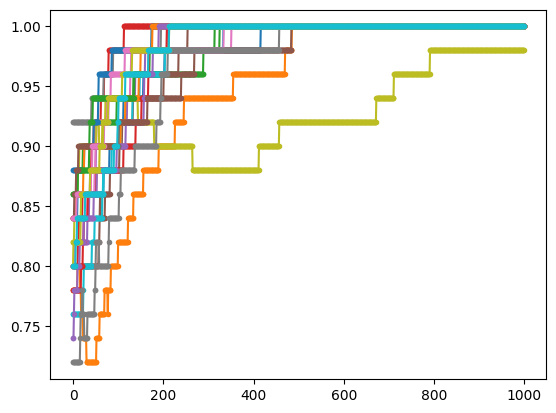

In [406]:
# set pars
mu = 0                  # Select one sample of the training data
num_samples = 20        # How many samples we will flip
beta = 20               # 
num_iter = 1000         # 
p_flip = 0.1           # Percentage of positions we will flip

# init network
x = np.tile(X[mu], num_samples).reshape(num_samples, N)    # Copy X[mu] P times
flip_init = np.random.rand(num_samples, N) <= p_flip       # Decide the positions you will flip
x[flip_init] = 1 - x[flip_init]                            # Flip the points

# run dynamics
xs = np.zeros((num_iter, num_samples, N))                  # 
for it in range(num_iter):
    xs[it] = x.copy()                                      # 
    h = x @ J.T + I[None]                                  # 
    select = np.random.randint(N, size=num_samples)
    prob = pr(-(2. * x[range(num_samples), select] - .1) * h[range(num_samples), select], beta) #(e^{bh})/(e^{bh}+e^{-bh})
    toflip = np.random.rand(num_samples) < prob
    x[toflip, select[toflip]] = 1 - x[toflip, select[toflip]]

# compute and plot overlaps
ov = np.einsum('tmi,i->mt', 2*xs-1, 2*X[mu]-1) / N

plt.plot(ov.T, '.-');

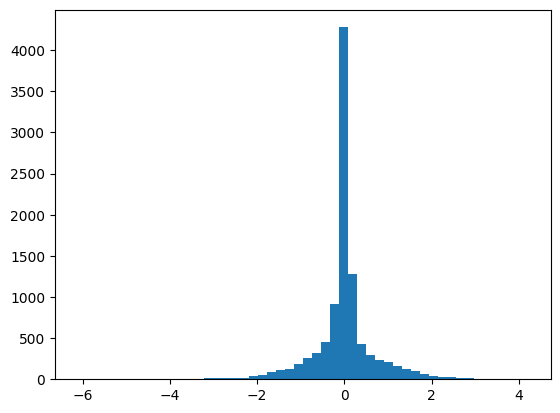

In [407]:
plt.hist(J.flatten(), bins=50);

In [408]:
flip_init[1]

array([False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False])

## Analysis

### Total fields before and after training

Before training:
delta_minus: 3.7624902329330867
delta_plus: -1.9343508828961686

After training:
delta_minus: -5.00047942824134
delta_plus: 5.052644462959597


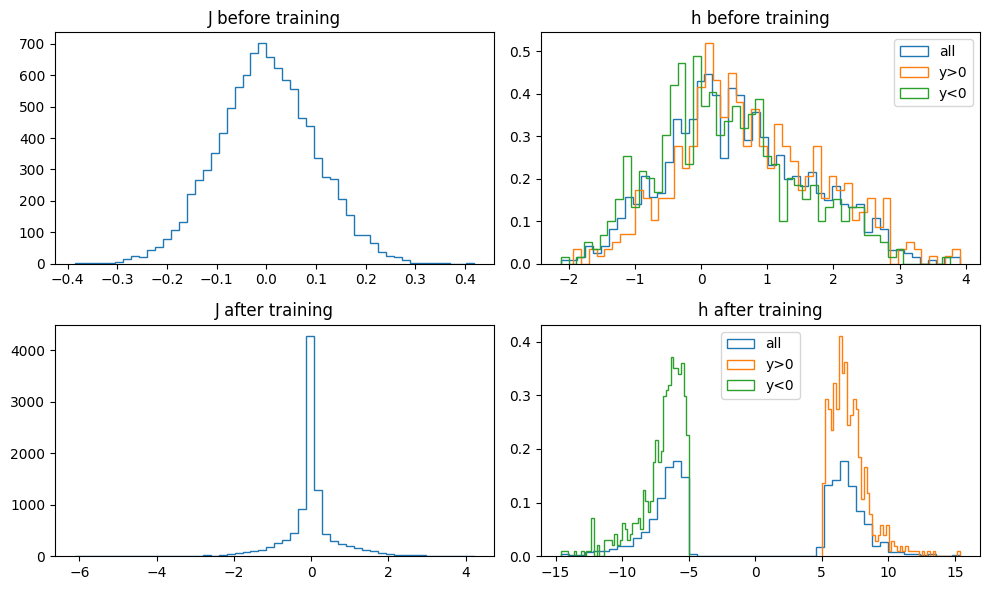

In [409]:
plt.figure(figsize=(10,6))

# before training
Hs0 = X @ J0.T + I[None]
delta_minus0 = np.max(Hs0[Y<0])
delta_plus0 = np.min(Hs0[Y>0])
print("Before training:")
print("delta_minus:", delta_minus0)
print("delta_plus:", delta_plus0)

plt.subplot(221)
plt.hist(J0.flatten(), bins=50, histtype="step");
plt.title('J before training')
plt.subplot(222)
plt.hist(Hs0.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs0[Y>0], bins=50, density=True, histtype="step", label='y>0');
plt.hist(Hs0[Y<0], bins=50, density=True, histtype="step", label='y<0');
plt.title('h before training')
plt.legend();

# after training
Hs = X @ J.T + I[None]
delta_minus = np.max(Hs[Y<0])
delta_plus = np.min(Hs[Y>0])
print("\nAfter training:")
print("delta_minus:", delta_minus)
print("delta_plus:", delta_plus)

plt.subplot(223)
plt.hist(J.flatten(), bins=50, histtype="step");
plt.title('J after training')
plt.subplot(224)
plt.hist(Hs.flatten(), bins=50, density=True, histtype="step", label='all');
plt.hist(Hs[Y>0], bins=50, density=True, histtype="step", label='y>0');
plt.hist(Hs[Y<0], bins=50, density=True, histtype="step", label='y<0');
plt.title('h after training')
plt.legend();

plt.tight_layout();

### Effective signs for the recurrent weights

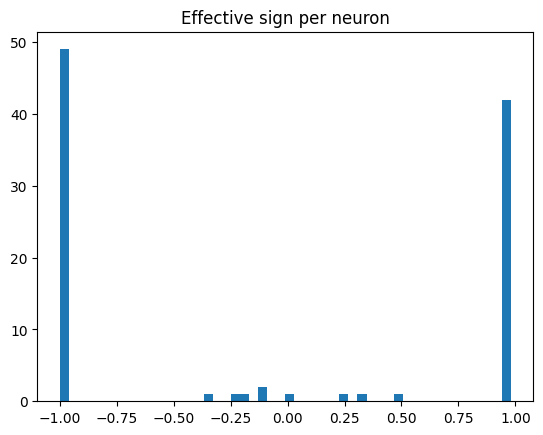

fe_eff: 0.45
J_eff:
[[ 0.42519433 -0.35420026]
 [ 0.45318716 -0.36932088]]
I_eff:
[0.37333334 0.78181819]


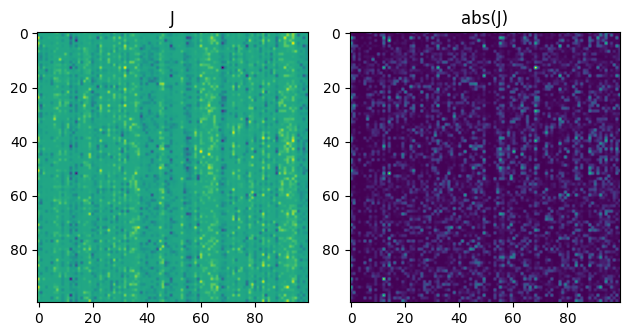

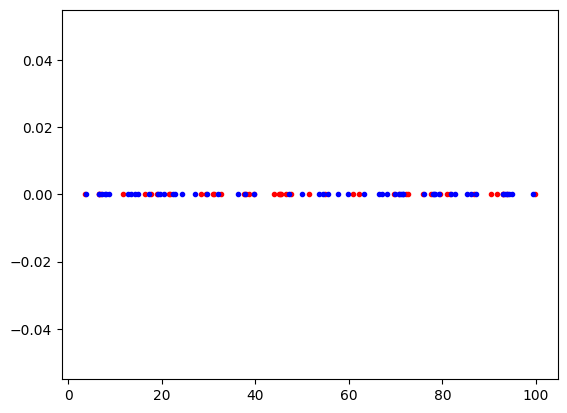

In [410]:
## Poorly defined quantity: must probably find a better one that filters out zero weights
signJ = (2. * (J > 0.) - 1.).mean(0)

if fe > 0:
    indE = range(Ne)
    indI = range(Ne,N)
else:
    indE = np.arange(N)[signJ > 1e-6]
    indI = np.arange(N)[signJ <= 1e-6]

# plt.plot(signJ, '.-');
plt.hist(signJ, bins=50);
plt.title('Effective sign per neuron')
plt.show()
    
Ne_eff = (signJ>0).sum()
Ni_eff = N - Ne_eff
fe_eff = Ne_eff / N
print('fe_eff:', fe_eff)


JEE = J[indE][:,indE]
JEI = J[indE][:,indI]
JIE = J[indI][:,indE]
JII = J[indI][:,indI]

J_eff = np.array([[JEE.mean(), JEI.mean()],
                 [JIE.mean(), JII.mean()]])
print("J_eff:")
print(J_eff)

I_eff = np.array([I[indE].mean(), I[indI].mean()])
print("I_eff:")
print(I_eff)

if embed_model:
    plt.subplot(121)
    plt.imshow(J, origin='upper');
    plt.title('J')
    plt.subplot(122)
    plt.imshow(np.abs(J), origin='upper');
    plt.title('abs(J)')
    plt.tight_layout();
    plt.show()

    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=3, c='red')
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=3, c='blue')
        plt.show()
    else:
        plt.imshow(np.sign(signJ).reshape(lN,lN))

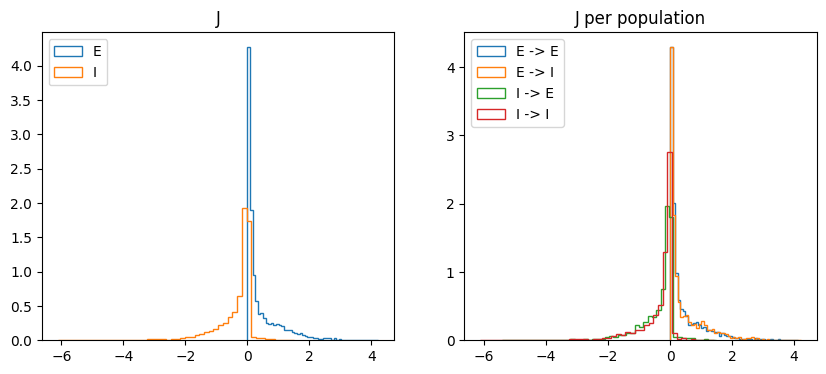

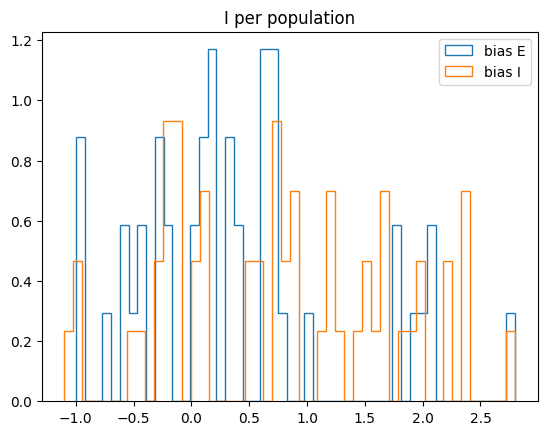

In [411]:
# weights per population

if fe == -1 and not gam_sign:
    plt.hist(J.flatten(), bins=50, density=True, histtype="step", label='J');
#     plt.hist(I, bins=50, density=True, histtype="step", label='bias');
    plt.legend();
else:
    plt.figure(figsize=(10,4))
    
    plt.subplot(121)
    plt.hist(J[:,indE].flatten(), bins=50, density=True, histtype="step", label='E');
    plt.hist(J[:,indI].flatten(), bins=50, density=True, histtype="step", label='I');
    plt.title('J')
    plt.legend()

    plt.subplot(122)
    plt.hist(J[indE][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> E");
    plt.hist(J[indI][:,indE].flatten(), density=True, bins=50, histtype="step", label="E -> I");
    plt.hist(J[indE][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> E");
    plt.hist(J[indI][:,indI].flatten(), density=True, bins=50, histtype="step", label="I -> I");
    plt.title('J per population')
    plt.legend();
    
    plt.show()
    plt.hist(I[indE], bins=50, density=True, histtype="step", label='bias E');
    plt.hist(I[indI], bins=50, density=True, histtype="step", label='bias I');
    plt.title('I per population')
    plt.legend();

### Look at receptive and projective fields

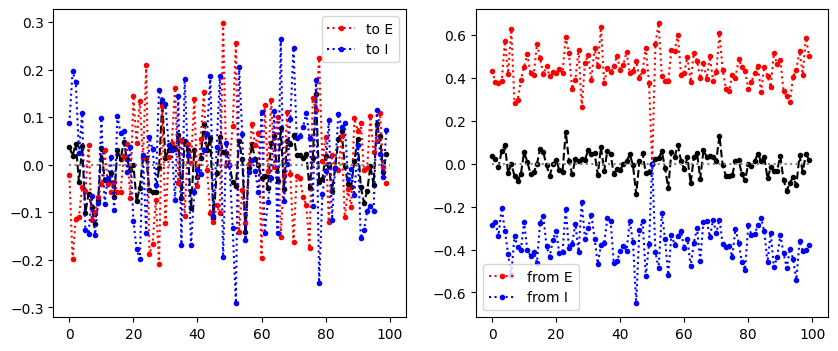

In [412]:
Jmeanto = np.zeros(N)
Jmeanfrom = np.zeros(N)
JmeantoE = np.zeros(N)
JmeantoI = np.zeros(N)
JmeanfromE = np.zeros(N)
JmeanfromI = np.zeros(N)
for k in range(N):
    Jmeanto += np.roll(J[k], -k+N//2) * 1/N
    Jmeanfrom += np.roll(J[:,k], -k+N//2) * 1/N
    if k in indE:
        JmeantoE += np.roll(J[k], -k+N//2) / Ne_eff
        JmeanfromE += np.roll(J[:,k], -k+N//2) / Ne_eff
    if k in indI:
        JmeantoI += np.roll(J[k], -k+N//2) / Ni_eff
        JmeanfromI += np.roll(J[:,k], -k+N//2) / Ni_eff
    
plt.figure(figsize=(10,4))

if dim == 1:
    plt.subplot(121)
    plt.plot(Jmeanto, '.--', c='k', );
    plt.plot(JmeantoE, '.:', c='red', label='to E');
    plt.plot(JmeantoI, '.:', c='blue', label='to I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');
    plt.legend();

    plt.subplot(122)
    plt.plot(Jmeanfrom, '.--', c='k');
    plt.plot(JmeanfromE, '.:', c='red', label='from E');
    plt.plot(JmeanfromI, '.:', c='blue', label='from I');
    plt.hlines(y=0, xmin=0, xmax=N, color='gray', ls=':');

    plt.legend();
else:
    plt.subplot(231)
    plt.imshow(Jmeanto.reshape(lN,lN))
    plt.subplot(232)
    plt.imshow(JmeantoE.reshape(lN,lN))
    plt.subplot(233)
    plt.imshow(JmeantoI.reshape(lN,lN))
    
    plt.subplot(234)
    plt.imshow(Jmeanfrom.reshape(lN,lN))
    plt.subplot(235)
    plt.imshow(JmeanfromE.reshape(lN,lN))
    plt.subplot(236)
    plt.imshow(-JmeanfromI.reshape(lN,lN))

### Receptive fields in space

neuron: 20
sign: -1.0


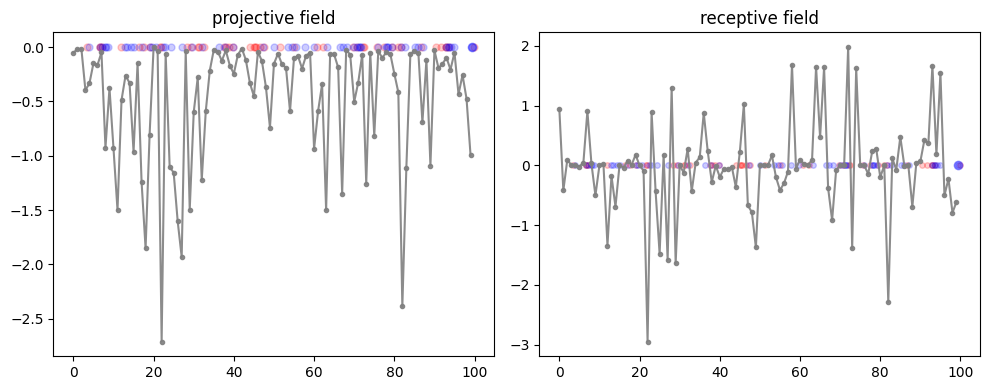

In [413]:
if embed_model:
    ind = 10
    # k = indE[ind]
    k = indI[ind]
    # k = ind
    print("neuron:", k)
    print("sign:", signJ[k])
    color = "red" if signJ[k] > 0 else "blue"

    plt.figure(figsize=(10,4))

    plt.subplot(121)
    plt.title('projective field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=5, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=5, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.4);
        plt.plot(J[:,k], '.-', alpha=0.9, c='gray')
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(np.abs(J[:,k]).reshape(lN,lN))

    plt.subplot(122)
    plt.title('receptive field')
    if dim == 1:
        plt.plot(pos[indE], 0 * np.ones_like(pos[indE]), 'o', ms=4, c='red', alpha=0.2)
        plt.plot(pos[indI], 0 * np.ones_like(pos[indI]), 'o', ms=4, c='blue', alpha=0.2)
        plt.plot(pos[k], 0, 'o', c=color, alpha=0.4);
        plt.plot(J[k], '.-', alpha=0.9, c='gray');
    else:
        plt.plot(pos[k,1], pos[k,0], 'o', c=color);
        plt.imshow(J[k].reshape(lN,lN));

    plt.tight_layout();

### Look at E and I populations separately

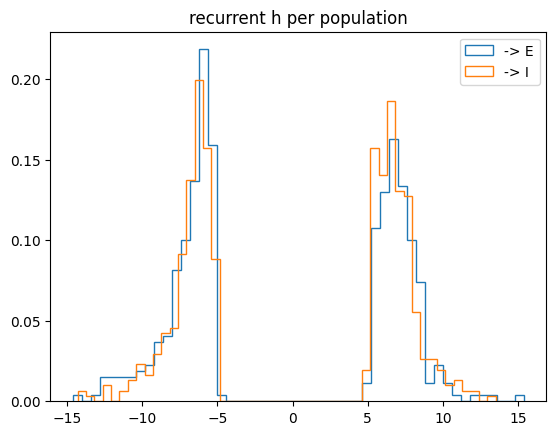

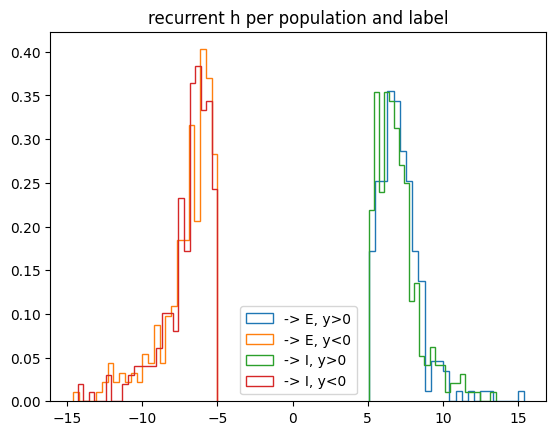

In [414]:
# fields per population
HfromE = X[:,indE] @ J[:,indE].T
HfromI = X[:,indI] @ J[:,indI].T

plt.hist(Hs[:,indE].flatten(), bins=50, density=True, histtype="step", label='-> E');
plt.hist(Hs[:,indI].flatten(), bins=50, density=True, histtype="step", label='-> I');
plt.title('recurrent h per population')
plt.legend();
plt.show();

plt.hist(Hs[:,indE][Y[:,indE]>0].flatten(), bins=25, density=True, histtype="step", label='-> E, y>0');
plt.hist(Hs[:,indE][Y[:,indE]<0].flatten(), bins=25, density=True, histtype="step", label='-> E, y<0');
plt.hist(Hs[:,indI][Y[:,indI]>0].flatten(), bins=25, density=True, histtype="step", label='-> I, y>0');
plt.hist(Hs[:,indI][Y[:,indI]<0].flatten(), bins=25, density=True, histtype="step", label='-> I, y<0');
plt.title('recurrent h per population and label')
plt.legend();
plt.show();

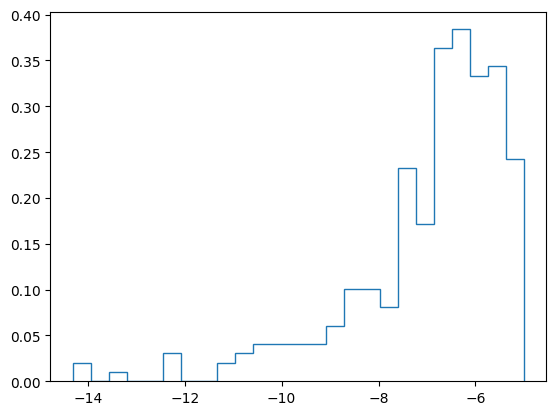

In [415]:
plt.hist(Hs[:,indI][Y[:,indI]<0].flatten(), bins=25, density=True, histtype="step", label='-> I, y<0');

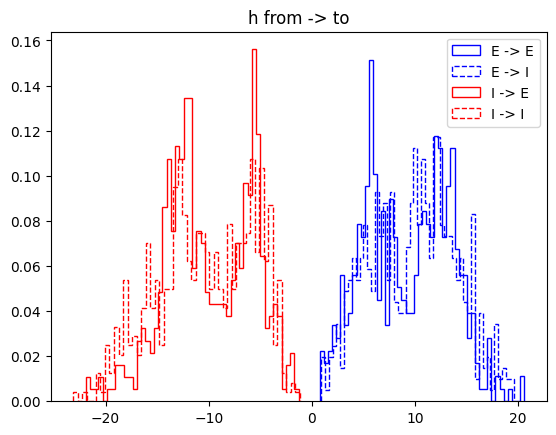

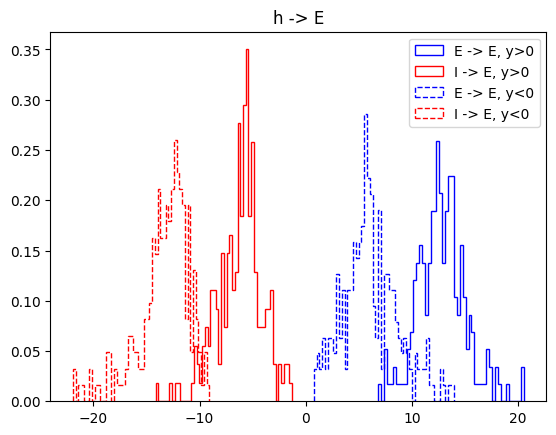

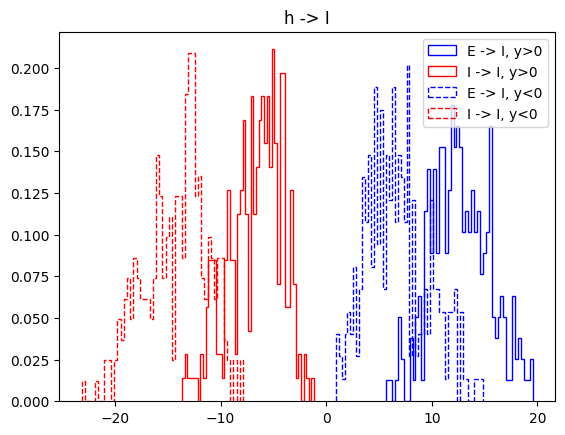

In [416]:
# fields per channel
plt.hist(HfromE[:,indE].flatten(), bins=50, density=True, histtype="step", label='E -> E', color='blue');
plt.hist(HfromE[:,indI].flatten(), bins=50, density=True, histtype="step", label='E -> I', color='blue', ls='--');
plt.hist(HfromI[:,indE].flatten(), bins=50, density=True, histtype="step", label='I -> E', color='red');
plt.hist(HfromI[:,indI].flatten(), bins=50, density=True, histtype="step", label='I -> I', color='red', ls='--');
plt.title('h from -> to')
plt.legend();
plt.show()

## fields to E per label
plt.hist(HfromE[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> E, y>0');
plt.hist(HfromI[:,indE][Y[:,indE]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> E, y>0');
plt.hist(HfromE[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> E, y<0');
plt.hist(HfromI[:,indE][Y[:,indE]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> E, y<0');
plt.title('h -> E')
plt.legend();
plt.show()

## fields to I per label
plt.hist(HfromE[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='blue', histtype="step", label='E -> I, y>0');
plt.hist(HfromI[:,indI][Y[:,indI]>0].flatten(), bins=50, density=True, color='red', histtype="step", label='I -> I, y>0');
plt.hist(HfromE[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='blue', ls='--', histtype="step", label='E -> I, y<0');
plt.hist(HfromI[:,indI][Y[:,indI]<0].flatten(), bins=50, density=True, color='red', ls='--', histtype="step", label='I -> I, y<0');
plt.title('h -> I')
plt.legend();
plt.show()